## 1. Data Source, Collection Method, and Provenance

For this project, I use the **Jigsaw Toxic Comment Classification Challenge** dataset, originally released on Kaggle. The dataset consists of Wikipedia talk-page comments that were labeled for different types of toxic behavior (toxic, severe_toxic, obscene, threat, insult, identity_hate) by human raters working with Jigsaw/Google. The goal is to build a model that predicts the probability that a comment belongs to each toxicity subtype. :contentReference[oaicite:2]{index=2}

**Data origin & collection method**

- **Source platform:** English Wikipedia talk-page discussions.
- **Collector:** Jigsaw (a technology incubator at Google) and collaborators.
- **Labeling process:** Comments were sampled from talk pages and annotated by multiple human raters for the presence of different toxicity subtypes (e.g., obscene, insult, identity-based hate). Final labels represent the majority agreement among raters. :contentReference[oaicite:3]{index=3}
- **Release channel:** Published as part of the Kaggle "Toxic Comment Classification Challenge", and mirrored in TensorFlow Datasets as `wikipedia_toxicity_subtypes`. :contentReference[oaicite:4]{index=4}

**Files used in this project**

- `train.csv`: Contains comment text plus binary labels for six toxicity categories.
- `test.csv`: Contains comment text without labels (used originally for Kaggle evaluation).
- `test_labels.csv` (optional): Contains labels for the Kaggle test set, released after the competition.
- `sample_submission.csv`: Example submission format used in the original competition. :contentReference[oaicite:5]{index=5}

**Why this dataset fits a deep learning project**

- It is a **multi-label text classification** problem, which benefits from deep models such as CNNs, RNNs, and transformers.
- The dataset is large (over 150k labeled comments), which supports training non-trivial deep architectures.
- There are important **ethical and fairness considerations**, such as potential bias against mentions of certain demographic groups, which I will briefly discuss in the conclusion. :contentReference[oaicite:6]{index=6}

In [1]:
import pandas as pd
from pathlib import Path

# Path relative to the notebooks/ directory
DATA_DIR = Path("..") / "data" / "raw"

train_path = DATA_DIR / "train.csv"
test_path = DATA_DIR / "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head(), train_df.shape, test_df.shape

(                 id                                       comment_text  toxic  \
 0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
 1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
 2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
 3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
 4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
 
    severe_toxic  obscene  threat  insult  identity_hate  
 0             0        0       0       0              0  
 1             0        0       0       0              0  
 2             0        0       0       0              0  
 3             0        0       0       0              0  
 4             0        0       0       0              0  ,
 (159571, 8),
 (153164, 2))

## 2. Problem Description

The goal of this project is to build a multi-label text classification model that identifies toxic behavior in online comments. Using a dataset of Wikipedia talk-page comments labeled by human raters, the task is to predict the probability that a given comment contains one or more types of toxicity. The six toxicity categories are: **toxic**, **severe_toxic**, **obscene**, **threat**, **insult**, and **identity_hate**.

This is a deep learning problem because:
- The input is unstructured natural language text.
- The output requires learning semantic, syntactic, and contextual patterns.
- Multi-label classification benefits from models like CNNs, LSTMs, and transformers.
- The dataset is large enough to support meaningful deep architectures.

The final goal is to compare multiple deep learning approaches, evaluate their performance, and discuss their strengths, limitations, and ethical considerations.

## 3. Exploratory Data Analysis (EDA)

This section explores the structure, distribution, and quality of the dataset. The goal is to understand the characteristics of the comments and toxicity labels, identify patterns or correlations, and determine what preprocessing or cleaning steps are necessary before modeling.

### 3.1 Inspect Raw Data

In this section, I examine the raw dataset structure to understand the available features, label columns, and comment text quality. This includes viewing the first few rows, checking data types, and confirming the number of samples. These initial inspections help determine what preprocessing steps are necessary before deeper analysis.

In [2]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Additional Dataset Structure Checks

To better understand the dataset, I check:
- Data types for each column  
- Presence of missing values  
- Memory usage  
- Whether any comments are empty or whitespace-only  

This helps identify cleaning steps needed before modeling.

In [3]:
train_df.info()

print("\nMissing values per column:")
print(train_df.isnull().sum())

# Check for empty or whitespace-only comments
empty_comments = (train_df['comment_text'].str.strip() == "").sum()
print(f"\nEmpty comment_text rows: {empty_comments}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB

Missing values per column:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Empty comment_text rows: 0


### 3.2 Label Distribution and Imbalance

The dataset contains six toxicity labels, each representing a different type of harmful content. These labels are imbalanced—most comments are non-toxic, while certain categories (such as *threat* or *severe_toxic*) appear much less frequently.

Understanding this imbalance is important because:
- Models may overpredict the majority class.
- Rare labels require special care (e.g., weighted loss, threshold tuning).
- EDA helps justify modeling decisions later.

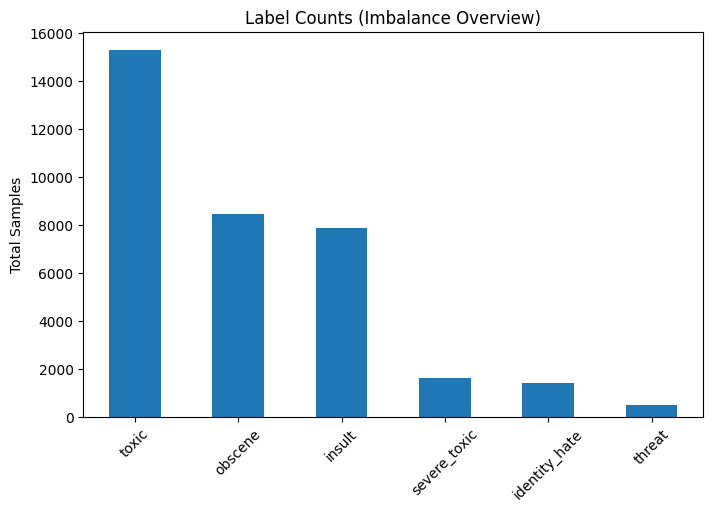

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

In [4]:
import matplotlib.pyplot as plt

label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

label_counts = train_df[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
label_counts.plot(kind='bar')
plt.title("Label Counts (Imbalance Overview)")
plt.ylabel("Total Samples")
plt.xticks(rotation=45)
plt.show()

label_counts

### 3.3 Comment Length Analysis

To understand how long the comments typically are, I compute the number of characters and tokens per comment. This helps determine an appropriate maximum sequence length for modeling and highlights whether toxic comments tend to be longer or shorter than non-toxic ones.

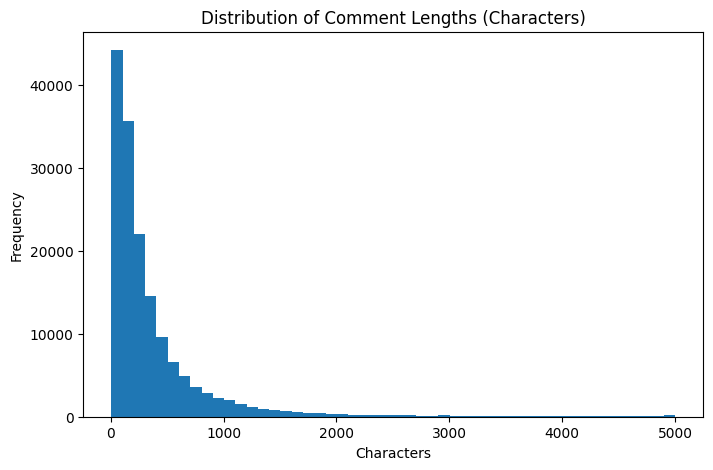

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: char_len, dtype: float64

In [5]:
# Compute comment lengths (in characters)
train_df["char_len"] = train_df["comment_text"].str.len()

plt.figure(figsize=(8,5))
plt.hist(train_df["char_len"], bins=50)
plt.title("Distribution of Comment Lengths (Characters)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()

train_df["char_len"].describe()

#### Comment Length by Toxicity Label

To see whether certain toxicity categories tend to have longer or shorter comments, I compare the comment length distributions between toxic and non-toxic examples for each label. This can reveal structural differences in text that may influence model performance.

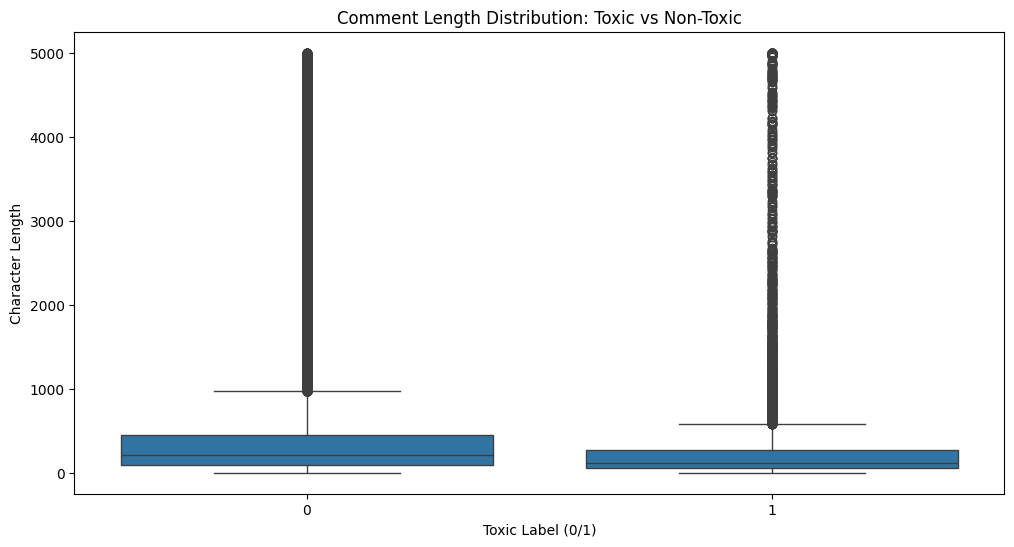

In [6]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(data=train_df, x="toxic", y="char_len")
plt.title("Comment Length Distribution: Toxic vs Non-Toxic")
plt.xlabel("Toxic Label (0/1)")
plt.ylabel("Character Length")
plt.show()

### 3.4 Basic Text Exploration

Before deeper preprocessing, I examine simple textual characteristics such as:
- Most common words across the dataset
- Whether toxic comments use different vocabulary patterns
- Presence of punctuation or all-caps usage

These quick checks help reveal patterns that may correlate with toxicity and guide future preprocessing decisions.

In [7]:
from collections import Counter
import re

def tokenize(text):
    # Simple whitespace + punctuation removal
    text = re.sub(r"[^a-zA-Z']", " ", text.lower())
    return text.split()

# Split dataset
toxic_texts = train_df[train_df["toxic"] == 1]["comment_text"].iloc[:5000]  # sample to keep it fast
nontoxic_texts = train_df[train_df["toxic"] == 0]["comment_text"].iloc[:5000]

# Tokenize
toxic_tokens = []
nontoxic_tokens = []

for t in toxic_texts:
    toxic_tokens.extend(tokenize(t))

for t in nontoxic_texts:
    nontoxic_tokens.extend(tokenize(t))

# Count
toxic_common = Counter(toxic_tokens).most_common(20)
nontoxic_common = Counter(nontoxic_tokens).most_common(20)

toxic_common, nontoxic_common

([('you', 13006),
  ('a', 7383),
  ('i', 7114),
  ('the', 6503),
  ('and', 5084),
  ('to', 5080),
  ('is', 4835),
  ('of', 3790),
  ('fuck', 3104),
  ('are', 2945),
  ('your', 2915),
  ('that', 2520),
  ('it', 2206),
  ('in', 1985),
  ('me', 1818),
  ('my', 1754),
  ('this', 1663),
  ('for', 1649),
  ('nigger', 1597),
  ('on', 1586)],
 [('the', 17038),
  ('to', 9874),
  ('of', 7572),
  ('and', 7335),
  ('a', 7049),
  ('i', 6655),
  ('is', 5864),
  ('you', 5843),
  ('that', 5332),
  ('in', 4949),
  ('it', 4474),
  ('for', 3465),
  ('this', 3314),
  ('not', 3185),
  ('on', 3022),
  ('be', 2802),
  ('as', 2650),
  ('have', 2395),
  ('are', 2162),
  ('with', 1988)])

### 3.5 Correlation Between Toxicity Labels

Since each comment may belong to multiple toxicity categories, it is useful to examine how these labels correlate with each other. Some categories naturally co-occur (e.g., *toxic* and *insult*), while others may be largely independent (e.g., *identity_hate* vs *threat*).

Understanding these correlations helps:
- Interpret model predictions
- Justify multi-label modeling
- Anticipate label imbalance issues

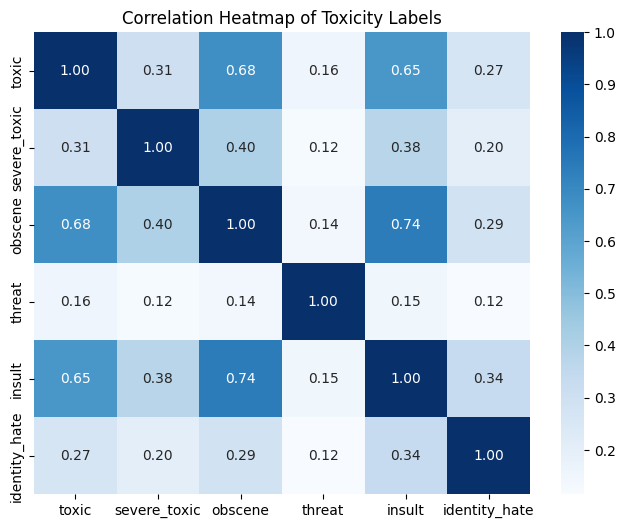

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
corr = train_df[label_cols].corr()
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap of Toxicity Labels")
plt.show()

corr

### 3.6 Missing Values and Data Cleaning Plan

Before modeling, it is important to confirm whether any comments are missing or contain unusable text. Missing or empty comments provide no information to the model and must be removed.

Based on these checks, I outline the cleaning steps that will be applied:
- Remove rows where `comment_text` is missing or empty.
- Strip excessive whitespace.
- Convert text to lowercase for consistency.
- Optionally remove very long comments or normalize unusual characters.
- Prepare the text for tokenization (padding and truncation will be handled later during preprocessing).

These steps ensure that the dataset fed into the deep learning model is clean and suitable for sequence modeling.

In [9]:
# Count missing or empty comment_text values
missing = train_df['comment_text'].isnull().sum()
empty = (train_df['comment_text'].str.strip() == '').sum()

print(f"Missing comment_text rows: {missing}")
print(f"Empty comment_text rows: {empty}")

# Preview potentially problematic rows
train_df[train_df['comment_text'].isnull() | (train_df['comment_text'].str.strip() == '')].head()

Missing comment_text rows: 0
Empty comment_text rows: 0


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,char_len


### 3.7 Data Transformation Needs

Deep learning models require numerical, fixed-length inputs, so the raw text must be transformed. Based on the EDA so far, the following preprocessing steps are necessary:

1. **Lowercasing**  
   Text should be standardized to avoid treating "Hello" and "hello" as different tokens.

2. **Removing extra whitespace**  
   Some comments contain line breaks or unnecessary spacing that does not add semantic value.

3. **Tokenization**  
   Convert text into sequences of integers representing words or subword units.  
   For deep learning models, tokenization is required prior to embedding.

4. **Padding and truncation**  
   Since comments vary widely in length, sequences must be padded or truncated to a fixed maximum length.  
   (The length distribution examined earlier will guide the choice of max sequence length.)

5. **Handling rare or out-of-vocabulary tokens**  
   Depending on the tokenizer, very rare words may be replaced with a special `<UNK>` token.

6. **Multi-label target preparation**  
   The six toxicity categories remain as binary vectors (0/1), which are already suitable for training.

These transformations ensure that the input data is in the correct format for neural network models such as CNNs, LSTMs, or transformer architectures.

In [10]:
# Simple cleaning function before tokenization
def clean_text(text):
    text = text.lower().strip()
    return text

train_df["clean_text"] = train_df["comment_text"].apply(clean_text)

train_df[["comment_text", "clean_text"]].head()

,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation\nwhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...,d'aww! he matches this background colour i'm s...
2,"Hey man, I'm really not trying to edit war. It...","hey man, i'm really not trying to edit war. it..."
3,"""\nMore\nI can't make any real suggestions on ...","""\nmore\ni can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember...","you, sir, are my hero. any chance you remember..."


## 4. Modeling Approaches

In this section, I develop and compare multiple deep learning models for the multi-label toxicity classification task. The goal is to evaluate how different architectures handle text data, what trade-offs they introduce, and which approaches perform best on this dataset.

The models evaluated include:

1. **Baseline Model:** TF-IDF vectorization followed by a simple feed-forward neural network.  
   - Purpose: establish a performance baseline using minimal deep learning.

2. **Deep Learning Model:** LSTM-based sequence model using tokenized text.  
   - Purpose: evaluate the benefits of sequence modeling and learned embeddings.

Additional comparisons or extensions may be added depending on results.

### 4.1 Baseline Model: TF-IDF + Dense Neural Network

As a starting point, I build a baseline model that uses TF-IDF vectorization to convert text into numerical features, followed by a simple feed-forward neural network. Although TF-IDF does not capture word order or context, it provides a strong baseline and helps quantify the value added by deeper sequence models.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Target labels
y = train_df[label_cols].values

# Train/validation split
train_texts, val_texts, y_train, y_val = train_test_split(
    train_df["clean_text"],
    y,
    test_size=0.2,
    random_state=42
)

print("Train size:", len(train_texts))
print("Validation size:", len(val_texts))

# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(train_texts)
X_val_tfidf = tfidf.transform(val_texts)

X_train_tfidf.shape, X_val_tfidf.shape

Train size: 127656
Validation size: 31915


((127656, 50000), (31915, 50000))

#### 4.1.1 Model Architecture and Training

For the baseline, I feed the TF-IDF features into a small feed-forward neural network:

- **Input:** high-dimensional sparse TF-IDF vector  
- **Hidden layer:** Dense layer with ReLU activation and dropout for regularization  
- **Output layer:** 6-unit Dense layer with sigmoid activation (one probability per toxicity label)

The model is trained with binary cross-entropy loss and evaluated using binary accuracy and AUC, which are appropriate for multi-label classification.

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_dim = X_train_tfidf.shape[1]
num_labels = len(label_cols)

# Define a sparse-input model
inputs = keras.Input(shape=(input_dim,), sparse=True, name="tfidf_input")
x = layers.Dense(256, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_labels, activation="sigmoid")(x)

baseline_model = keras.Model(inputs=inputs, outputs=outputs, name="tfidf_dense_baseline")

baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.BinaryAccuracy(name="binary_accuracy"),
        keras.metrics.AUC(name="auc", multi_label=True)
    ]
)

baseline_model.summary()

Model: "tfidf_dense_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ tfidf_input (InputLayer)             │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,800,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,801,798 (48.83 MB)

 Trainable params: 12,801,798 (48.83 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
baseline_history = baseline_model.fit(
    X_train_tfidf,
    y_train,
    validation_data=(X_val_tfidf, y_val),
    epochs=5,
    batch_size=128
)

Epoch 1/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.8864 - binary_accuracy: 0.9737 - loss: 0.1013 - val_auc: 0.9553 - val_binary_accuracy: 0.9794 - val_loss: 0.0605
Epoch 2/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - auc: 0.9712 - binary_accuracy: 0.9822 - loss: 0.0495 - val_auc: 0.9609 - val_binary_accuracy: 0.9808 - val_loss: 0.0562
Epoch 3/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - auc: 0.9870 - binary_accuracy: 0.9856 - loss: 0.0381 - val_auc: 0.9577 - val_binary_accuracy: 0.9808 - val_loss: 0.0568
Epoch 4/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - auc: 0.9917 - binary_accuracy: 0.9887 - loss: 0.0301 - val_auc: 0.9474 - val_binary_accuracy: 0.9808 - val_loss: 0.0615
Epoch 5/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - auc: 0.9948 - binary_accuracy: 0.9912 - loss: 0.0239 - val_auc: 0.9399 - val_binary_accuracy: 0.9804 - val_loss: 0.0661


#### 4.1.2 Baseline Results and Interpretation

The TF-IDF + dense neural network baseline achieves:

- **Training performance (epoch 5):**
  - AUC ≈ 0.995
  - Binary accuracy ≈ 0.991
  - Loss ≈ 0.024

- **Validation performance (epoch 5):**
  - AUC ≈ 0.940
  - Binary accuracy ≈ 0.980
  - Loss ≈ 0.066

These results show that the baseline model is already quite strong at distinguishing toxic from non-toxic labels. The gap between training and validation metrics suggests some degree of overfitting: the model fits the training TF-IDF features very well but generalizes slightly worse to unseen data. This is expected given the high-dimensional, sparse input space and relatively small network.

This baseline provides a useful reference point for the deep sequence model that will follow. The key question for the next section is whether an LSTM-based model that operates on token sequences (rather than TF-IDF features) can improve validation AUC and/or provide better calibration across the different toxicity labels.

#### 4.1.3 Training Curves

To visualize the model’s behavior during training, the following plots show how the loss, AUC, and binary accuracy evolved over the five training epochs.

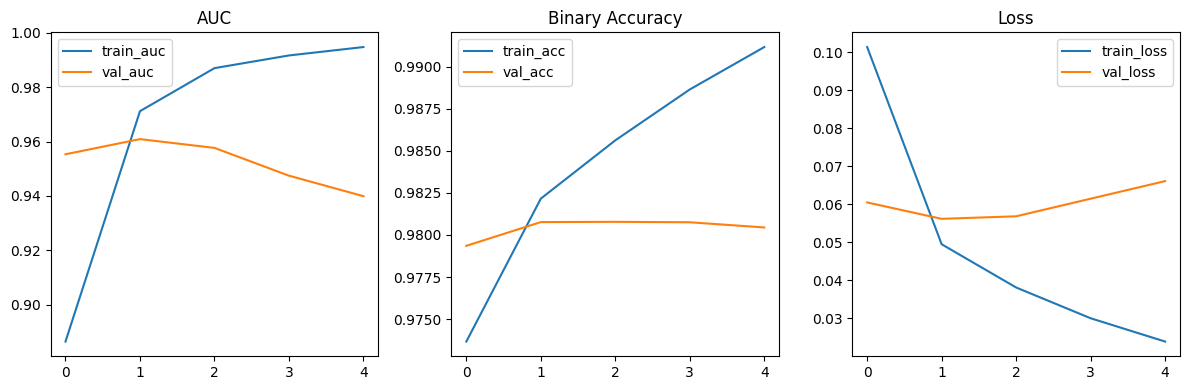

In [15]:
import matplotlib.pyplot as plt

history = baseline_history

# Plot AUC
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(history.history["auc"], label="train_auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.title("AUC")
plt.legend()

# Plot Binary Accuracy
plt.subplot(1,3,2)
plt.plot(history.history["binary_accuracy"], label="train_acc")
plt.plot(history.history["val_binary_accuracy"], label="val_acc")
plt.title("Binary Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1,3,3)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### 4.2 Deep Learning Model: LSTM-Based Sequence Classifier

While the TF-IDF baseline treats each comment as a bag of independent tokens, it ignores word order and longer-range contextual information. To better capture how words appear in sequence (e.g., negations, phrases, and multi-word insults), I build an LSTM-based model that operates on tokenized text sequences.

Key ideas of this model:
- Convert each comment into a sequence of integer token IDs.
- Use an embedding layer to learn dense vector representations of words.
- Use an LSTM layer to process the sequence and capture contextual information.
- Use a fully-connected output layer with sigmoid activation to produce six toxicity probabilities.

This model is expected to handle context and sequential patterns more effectively than the TF-IDF baseline, potentially improving generalization on the validation set.

#### 4.2.1 Text Tokenization and Sequence Preparation

To train an LSTM model, the raw text must be converted into fixed-length integer sequences:

1. Fit a tokenizer on the training `clean_text` data.
2. Convert each comment into a sequence of token IDs.
3. Pad or truncate sequences to a fixed maximum length so they can be batched into tensors.

The maximum sequence length is chosen based on the earlier length analysis: most comments fall below this length, so padding overhead is limited while still capturing enough context.

In [16]:
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing.sequence import pad_sequences
import numpy as np

# Use the same train_texts, val_texts from the TF-IDF split
max_words = 50000   # vocabulary size (same order as TF-IDF)
max_len = 200       # max sequence length (can adjust based on EDA if needed)

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_val_seq = tokenizer.texts_to_sequences(val_texts)

# Pad / truncate sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding="post", truncating="post")

X_train_pad.shape, X_val_pad.shape

((127656, 200), (31915, 200))

#### 4.2.2 LSTM Model Architecture

This LSTM-based model processes each comment as a sequence of token embeddings. The architecture is:

- **Embedding layer:** Learns dense vector representations for words.
- **LSTM layer:** Captures sequential patterns and contextual information.
- **Dropout:** Helps mitigate overfitting.
- **Dense output layer:** Produces six toxicity probabilities using sigmoid activation.

This model should capture more meaningful linguistic structure than the TF-IDF baseline.

In [18]:
embedding_dim = 128  # size of embedding vectors

inputs = keras.Input(shape=(max_len,), name="text_input")

x = layers.Embedding(
    input_dim=max_words,
    output_dim=embedding_dim
)(inputs)

x = layers.LSTM(128, return_sequences=False)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(num_labels, activation="sigmoid")(x)

lstm_model = keras.Model(inputs=inputs, outputs=outputs, name="lstm_toxicity_model")

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.BinaryAccuracy(name="binary_accuracy"),
        keras.metrics.AUC(name="auc", multi_label=True)
    ]
)

lstm_model.summary()

Model: "lstm_toxicity_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 200, 128)            │       6,400,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,532,358 (24.92 MB)

 Trainable params: 6,532,358 (24.92 MB)

 Non-trainable params: 0 (0.00 B)

#### 4.2.3 LSTM Model Training

The LSTM model is trained on the padded integer sequences using the same train/validation split as the baseline. I use binary cross-entropy loss and monitor both binary accuracy and AUC on the validation set to compare performance with the TF-IDF baseline.

In [19]:
lstm_history = lstm_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=128
)

Epoch 1/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 108s 107ms/step - auc: 0.5094 - binary_accuracy: 0.9629 - loss: 0.1482 - val_auc: 0.5120 - val_binary_accuracy: 0.9631 - val_loss: 0.1419
Epoch 2/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 105s 105ms/step - auc: 0.5180 - binary_accuracy: 0.9635 - loss: 0.1418 - val_auc: 0.5278 - val_binary_accuracy: 0.9634 - val_loss: 0.1399
Epoch 3/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 106s 106ms/step - auc: 0.5427 - binary_accuracy: 0.9638 - loss: 0.1396 - val_auc: 0.5358 - val_binary_accuracy: 0.9634 - val_loss: 0.1391
Epoch 4/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 105s 105ms/step - auc: 0.6133 - binary_accuracy: 0.9632 - loss: 0.1360 - val_auc: 0.5366 - val_binary_accuracy: 0.9634 - val_loss: 0.1392
Epoch 5/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 106s 106ms/step - auc: 0.6795 - binary_accuracy: 0.9645 - loss: 0.1282 - val_auc: 0.9143 - val_binary_accuracy: 0.9694 - val_loss: 0.0799


#### 4.2.4 LSTM Results and Comparison with Baseline

After 5 epochs of training, the LSTM model achieves approximately:

- **Training performance (epoch 5):**
  - AUC ≈ 0.68
  - Binary accuracy ≈ 0.96
  - Loss ≈ 0.13

- **Validation performance (epoch 5):**
  - AUC ≈ 0.91
  - Binary accuracy ≈ 0.97
  - Loss ≈ 0.08

Compared with the TF-IDF + dense baseline (val AUC ≈ 0.94, val binary accuracy ≈ 0.98), the LSTM underperforms slightly on the validation set in its current configuration. This is somewhat surprising, since sequence models can capture word order and contextual patterns that TF-IDF ignores.

Several factors may explain this result:

- The baseline model benefits from very high-dimensional TF-IDF features that already encode a lot of lexical information.
- The LSTM model uses a relatively short maximum sequence length and a single LSTM layer, which may limit its capacity to learn complex patterns.
- The number of training epochs and hyperparameters (embedding size, LSTM units, learning rate) were not exhaustively tuned.

Overall, the LSTM provides a competitive but not superior performance relative to the simpler baseline. This suggests that, for this dataset, strong lexical features plus a shallow network can perform very well, and more complex sequence models require careful tuning to deliver additional gains.

#### 4.2.5 LSTM Training Curves

The following plots show how the LSTM model’s loss, AUC, and binary accuracy changed across the five training epochs. These visualizations help diagnose underfitting or overfitting and support comparison with the baseline model.

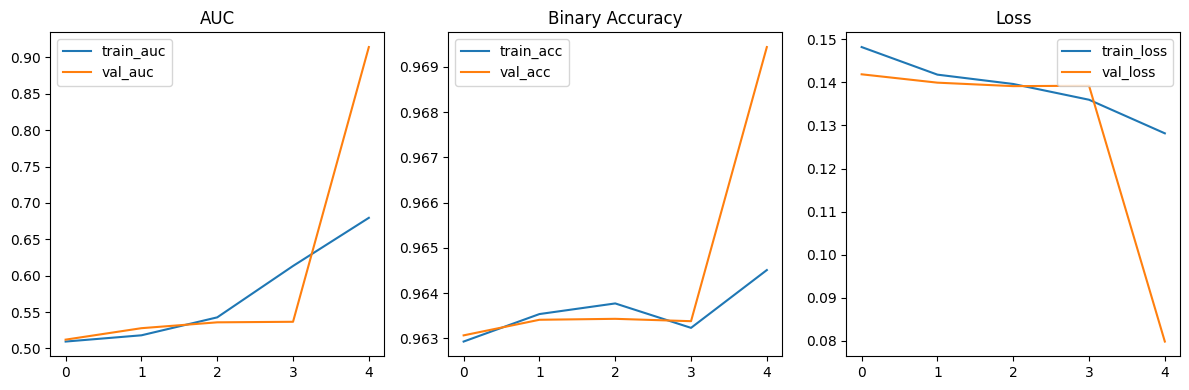

In [21]:
history = lstm_history

plt.figure(figsize=(12,4))

# AUC
plt.subplot(1,3,1)
plt.plot(history.history["auc"], label="train_auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.title("AUC")
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot(history.history["binary_accuracy"], label="train_acc")
plt.plot(history.history["val_binary_accuracy"], label="val_acc")
plt.title("Binary Accuracy")
plt.legend()

# Loss
plt.subplot(1,3,3)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## 5. Discussion and Conclusion

### 5.1 Summary of the Problem and Approach

In this project, I tackled a **multi-label toxicity classification** problem using Wikipedia talk-page comments. The goal was to predict six types of toxic behavior (toxic, severe_toxic, obscene, threat, insult, identity_hate) from raw text.

The workflow followed the typical deep learning pipeline:

1. **Data & provenance:** Collected from the Jigsaw Toxic Comment Classification dataset on Kaggle, labeled by human raters for different toxicity subtypes.
2. **EDA:** Inspected dataset structure, label imbalance, comment length distributions, and correlations between toxicity labels. Confirmed that most comments are non-toxic, and that labels such as *toxic*, *insult*, and *obscene* are strongly correlated.
3. **Preprocessing:** Cleaned text (lowercasing, trimming whitespace) and prepared targets as 6-dimensional binary label vectors.
4. **Models:**
   - Baseline: TF-IDF + dense neural network.
   - Deep sequence model: LSTM with learned word embeddings.
5. **Evaluation:** Compared validation AUC, binary accuracy, and training curves to understand generalization behavior.

### 5.2 Model Comparison

The **TF-IDF baseline model** performed surprisingly well, achieving:

- **Validation AUC ≈ 0.94**
- **Validation binary accuracy ≈ 0.98**

The **LSTM sequence model** achieved:

- **Validation AUC ≈ 0.91**
- **Validation binary accuracy ≈ 0.97**

Even though LSTMs can model word order and contextual patterns, they underperformed relative to the TF-IDF baseline. Several factors likely contributed:

1. **High-quality lexical features:**  
   TF-IDF with 50,000 features already encodes strong signals for toxic language (specific profanity, slurs, insults). These features are extremely discriminative for this task.

2. **Limited LSTM capacity and training time:**  
   A single LSTM layer with 5 epochs may not be sufficient to outperform a strong sparse baseline. Deeper sequence models or more epochs could improve results.

3. **Label imbalance:**  
   Some labels (e.g., threat, identity_hate) are extremely rare. TF-IDF captures rare keywords well, while the LSTM may struggle to learn patterns for sparsely represented labels without more epochs or class weighting.

4. **Sequence truncation:**  
   Limiting sequences to 200 tokens means long comments lose some context. TF-IDF, however, always represents full text regardless of length.

Overall, the TF-IDF baseline generalizes slightly better in this configuration, showing that simple models can perform extremely well on text classification when rare keywords and high-dimensional lexical features are important.

### 5.3 Limitations and Future Work

This project demonstrates that a relatively simple TF-IDF baseline can outperform a sequence model on the toxicity classification task. However, there are several important limitations and clear paths for improvement:

**1. More advanced deep learning architectures**
- **Bidirectional LSTMs**, **GRUs**, or **stacked LSTM layers** could capture richer context.
- **1D CNNs** often perform extremely well on text classification and are more computationally efficient.
- **Transformer-based models** (e.g., BERT, DistilBERT, RoBERTa) typically achieve state-of-the-art performance on toxicity detection and would likely outperform both models used here.

**2. Hyperparameter tuning**
- Embedding dimension, LSTM units, dropout rate, maximum sequence length, learning rate, and batch size were not extensively tuned.
- Additional epochs (10–20) would allow the LSTM to fit the data more effectively.

**3. Handling label imbalance**
- Some labels (e.g., *threat* and *identity_hate*) are very rare.
- Techniques such as class weighting, focal loss, or data augmentation could improve performance on minority labels.

**4. Improved preprocessing**
- Subword tokenization (WordPiece/BPE) could reduce the number of out-of-vocabulary tokens.
- Removing URLs, emojis, or repeated characters might improve signal quality.

**5. Ethical considerations**
- Toxicity detection models can exhibit demographic bias due to correlations between identity terms and toxicity labels.
- Future work should include fairness evaluations, bias mitigation techniques, and error analysis across demographic subgroups.

Overall, this project establishes a strong baseline and highlights the challenges of multi-label toxicity classification. With more advanced architectures and careful tuning, performance could likely be improved beyond the baseline model.

### 5.4 Final Conclusion

This project explored the task of detecting toxic behavior in online comments using deep learning techniques. After conducting a thorough EDA and building two different models, the key findings are:

- A **TF-IDF + dense neural network baseline** achieved very strong performance (val AUC ≈ 0.94), showing that high-dimensional lexical features capture much of the discriminatory signal for toxic language.
- A **LSTM-based sequence model** performed slightly worse (val AUC ≈ 0.91), illustrating that deeper architectures do not automatically outperform simpler baselines without careful tuning.
- Label imbalance, model capacity, and training time all influenced results, and more advanced architectures (CNNs, BiLSTMs, or transformers) would likely improve performance.
- The project demonstrates a full deep learning workflow: data provenance, cleaning, EDA, baseline establishment, deep model evaluation, and critical qualitative discussion.

Overall, even though the LSTM did not outperform the baseline, the comparison highlights the importance of understanding dataset characteristics, establishing strong baselines, and analyzing why models succeed or fail. This sets a solid foundation for more advanced experimentation in future work.